In [24]:
%matplotlib inline

import sys
sys.path.append('../..')

from matplotlib import pylab as plt

import itertools
import numpy
import scipy
import scipy.special
import time
import random

from ipywidgets import interact
from IPython.display import display, Markdown, clear_output

from crocodile.synthesis import *
from crocodile.simulate import *
from crocodile.antialias import *
from util.visualize import *
from arl.test_support import create_named_configuration, export_visibility_to_hdf5
from arl.data_models import *

First, some grid characteristics. Only theta is actually important here, the rest is just decides the range of the example $u/v$ values.

In [25]:
theta = 0.1
lam = 18000
grid_size = int(theta * lam)

Determine $u/v$ gridding function to use. Three choices here - trivial, Sze-Tan's version and PSWF. `x0` decides how much of the image coordinate space we can actually use without errors rising.

We use that to calculate the appropriate grid step length `du` for good accuracy in our target field of view `theta`:

Using Sze-Tan's gridder with R=3, x_0=0.25


Mean error: 1.64368852446e-06
Optimal du = 5.0


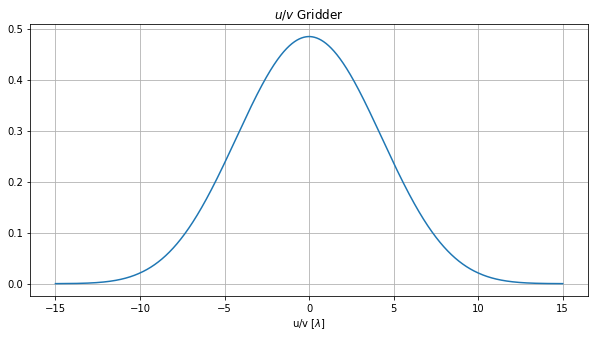

[ 0.04951909  0.04635579  0.04712115  0.05060831  0.0560945   0.06315665
  0.0715563   0.08116772  0.09193298  0.10383379  0.11687376  0.13106728
  0.14643229  0.16298567  0.18074009  0.19970191  0.21986963  0.24123281
  0.26377116  0.28745395  0.31223949  0.33807485  0.36489561  0.39262584
  0.42117816  0.45045398  0.48034386  0.51072799  0.54147689  0.57245214
  0.6035073   0.634489    0.66523804  0.69559069  0.72538003  0.75443738
  0.78259381  0.80968166  0.83553611  0.85999675  0.88290916  0.90412638
  0.92351044  0.94093371  0.95628025  0.96944698  0.98034476  0.98889936
  0.99505217  0.9987609   1.          0.9987609   0.99505217  0.98889936
  0.98034476  0.96944698  0.95628025  0.94093371  0.92351044  0.90412638
  0.88290916  0.85999675  0.83553611  0.80968166  0.78259381  0.75443738
  0.72538003  0.69559069  0.66523804  0.634489    0.6035073   0.57245214
  0.54147689  0.51072799  0.48034386  0.45045398  0.42117816  0.39262584
  0.36489561  0.33807485  0.31223949  0.28745395  0

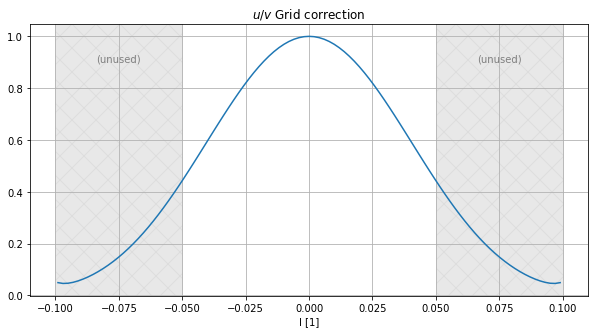

In [35]:
aa_over = 4096
aa_support = 6
aa_x0 = 0.25
aa_mode = 0
aa_szetan = True
if aa_support == 1:
    print("Using trivial gridder")
    aa_gcf = numpy.ones((aa_over, aa_support))
    def aa(x): return numpy.ones_like(x)
elif aa_szetan:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support//2, aa_x0))
    aa_gcf = sze_tan_gridder(aa_support//2, aa_x0, aa_over)
    def aa(x):
        return sze_tan_grid_correction_gen(aa_support//2, aa_x0, x)
    print("Mean error:", sze_tan_mean_error(aa_support//2, aa_x0))
else:
    aa_parameter = aa_support
    print("Using PSWF with mode %d and parameter %g" % (aa_mode, aa_parameter))
    aa_gcf = kernel_oversample(anti_aliasing_function(grid_size, aa_mode, aa_parameter), aa_over, aa_support)
    aa_gcf /= numpy.sum(aa_gcf[0])
    def aa(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter, 2*x)[0]
    
# Calculate appropriate step length to give us full accuracy for a field of view of size theta
du = du_opt = aa_x0/(theta/2)
print("Optimal du =", du)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support//2), aa_over*((aa_support+1)//2)) / aa_over
plt.plot(du_opt*r, numpy.transpose(aa_gcf).flatten().real);
plt.xticks(du_opt*numpy.arange(-(aa_support//2), ((aa_support+1)//2)+1))
plt.grid(True);plt.xlabel('u/v [$\lambda$]');plt.title('$u/v$ Gridder');plt.show()

# Plot grid correction function
theta_x0 = theta/aa_x0/2
x = coordinates(101)
#print(x)
sze_aa_im = aa(x)
print(sze_aa_im.shape)
plt.plot(theta*x/aa_x0/2, aa(x));
plt.title('$u/v$ Grid correction');plt.grid(True);plt.xlabel('l [1]')
plt.axvspan(theta/2, theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-theta/2, -theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((theta+theta_x0)/4,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(theta+theta_x0)/4,0.9), ha='center', color='gray');

Using Sze-Tan's gridder with R=2, x_0=0.125


Mean error: 7.1257870709e-06
max_n = 0.002503132837
Optimal dw = 49.9374216791


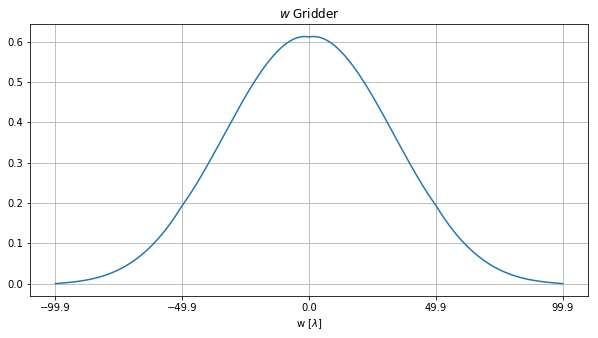

[ 0.22637738  0.2126835   0.20596314  0.20474932  0.2079147   0.21459257
  0.22411589  0.23597038  0.24975825  0.26517025  0.28196406  0.29994765
  0.3189664   0.33889324  0.35962107  0.38105692  0.40311757  0.42572616
  0.44880976  0.47229746  0.49611909  0.52020422  0.54448159  0.56887872
  0.59332168  0.61773508  0.64204216  0.6661649   0.69002432  0.71354073
  0.73663407  0.75922431  0.78123181  0.80257772  0.82318442  0.84297595
  0.86187838  0.8798203   0.89673317  0.91255173  0.92721442  0.94066368
  0.95284636  0.96371397  0.97322303  0.98133529  0.98801799  0.99324406
  0.99699224  0.99924729  0.99999999  0.99924729  0.99699224  0.99324406
  0.98801799  0.98133529  0.97322303  0.96371397  0.95284636  0.94066368
  0.92721442  0.91255173  0.89673317  0.8798203   0.86187838  0.84297595
  0.82318442  0.80257772  0.78123181  0.75922431  0.73663407  0.71354073
  0.69002432  0.6661649   0.64204216  0.61773508  0.59332168  0.56887872
  0.54448159  0.52020422  0.49611909  0.47229746  0

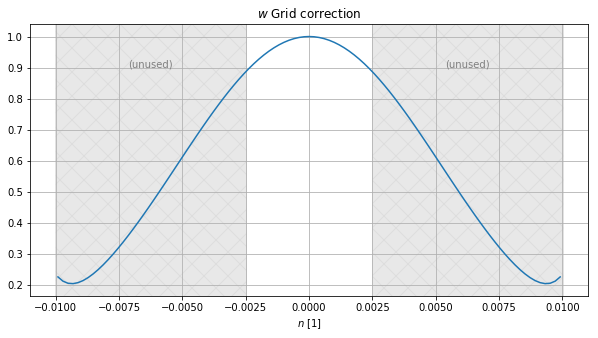

In [36]:
aa_support_w = 4
aa_x0_w = 0.125
aa_parameter_w = aa_support_w
aa_szetan_w = True
if aa_support_w == 1:
    print("Using trivial gridder")
    aa_gcf_w = numpy.ones((aa_over, aa_support_w))
    def aa_w(x): return numpy.ones_like(x)
elif aa_szetan_w:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support_w//2, aa_x0_w))
    aa_gcf_w = sze_tan_gridder(aa_support_w//2, aa_x0_w, aa_over)
    def aa_w(x):
        return sze_tan_grid_correction_gen(aa_support_w//2, aa_x0_w, x)
    print("Mean error:", sze_tan_mean_error(aa_support_w//2, aa_x0_w))
else:
    aa_gcf_w = kernel_oversample(anti_aliasing_function(grid_size, 0, aa_parameter_w), aa_over, aa_support_w)
    aa_gcf_w /= numpy.sum(aa_gcf_w[0])
    def aa_w(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter_w, 2*x)[0]

# Calculate appropriate step length to give us full accuracy for a field of view of size theta
max_n = 1.0 - numpy.sqrt(1.0 - 2*(theta/2)**2)
print("max_n =", max_n)
dw = dw_opt = aa_x0_w / max_n
print("Optimal dw =", dw)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support_w//2), aa_over*((aa_support_w+1)//2)) / aa_over
plt.plot(dw_opt*r, numpy.transpose(aa_gcf_w).flatten().real);
plt.xticks(dw_opt*numpy.arange(-(aa_support_w//2), ((aa_support_w+1)//2)+1))
plt.grid(True); plt.xlabel('w [$\lambda$]'); plt.title('$w$ Gridder'); plt.show()

x = coordinates(101)
sze_w_im = aa_w(x)
print(sze_w_im)
plt.plot(max_n*x/aa_x0_w, aa_w(x));
plt.title('$w$ Grid correction'); plt.grid(True); plt.xlabel('$n$ [1]');
max_n_x0 = max_n/aa_x0_w/2
plt.axvspan(max_n, max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-max_n, -max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((max_n+max_n_x0)/2,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(max_n+max_n_x0)/2,0.9), ha='center', color='gray');

Now generate some sources on the sky. We use a random pattern to make reasonably sure that we are not hand-picking a good sky pattern.

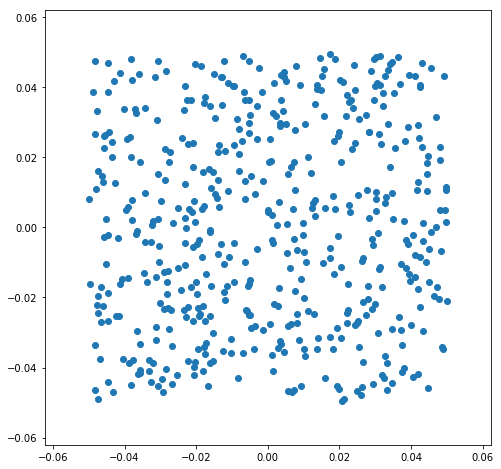

In [28]:
Npt = 500
points = theta * (numpy.random.rand(Npt,2)-0.5)

#points = list(theta/10 * numpy.array(list(itertools.product(range(-5, 6), range(-5, 6)))))
#points.append((theta/3,0))
#points = numpy.array(points)

plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(points[:,0], points[:,1]);

Set up code to predict visibilities - either directly or by visibilities weighted by the grid correction and offset in a grid-like fashion.

In [33]:

def predict(dist_uvw, du=du_opt, dw=dw_opt, apply_aa = False, apply_aa_w = False):
    # Get image coordinates
    ls, ms = numpy.transpose(points)
    ns = numpy.sqrt(1.0 - ls**2 - ms**2) - 1
    # Evaluate grid correction functions in uv & w
    aas = numpy.ones(len(ls))
    if apply_aa:
        aas *= aa(du*ls) * aa(du*ms)
    if apply_aa_w:
        aas *= aa_w(dw*ns)
    # Now simulate points, dividing out grid correction
    vis = 0
    for l,m, a in zip(ls, ms, aas):
        vis += simulate_point(dist_uvw, l, m) / a
    return vis

def predict_grid(u,v,w,ov_u,ov_v,ov_w,du=du_opt, dw=dw_opt, visualise=False):
    
    # Generate offsets that we are going to sample at
    ius, ivs, iws = numpy.meshgrid(numpy.arange(aa_support), numpy.arange(aa_support), numpy.arange(aa_support_w))
    dus = du*(ius.flatten()-(aa_support//2)+ov_u/aa_over)
    dvs = du*(ivs.flatten()-(aa_support//2)+ov_v/aa_over)
    dws = dw*(iws.flatten()-(aa_support_w//2)+ov_w/aa_over)
    
    # Get grid convolution function for offsets
    aas = aa_gcf[ov_u,ius.flatten()] * aa_gcf[ov_v,ivs.flatten()] * aa_gcf_w[ov_w,iws.flatten()]

    # Add offsets to all uvw coordinates
    us = numpy.array(u)[:,numpy.newaxis] + dus[numpy.newaxis,:]
    vs = numpy.array(v)[:,numpy.newaxis] + dvs[numpy.newaxis,:]
    ws = numpy.array(w)[:,numpy.newaxis] + dws[numpy.newaxis,:]
    
    # Visualise sampling pattern?
    if visualise:
        ax = plt.subplot(111, projection='3d')
        ax.scatter(us,vs,ws, color='red');
        ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')

    # Predict visibilities
    vis = predict(numpy.transpose([us.flatten(),vs.flatten(),ws.flatten()]),
                  du=du, dw=dw, apply_aa=True, apply_aa_w=True).reshape(us.shape)
    
    # Convolve with gridder, sum up
    return numpy.sum(vis * aas[numpy.newaxis,:], axis=1)


Now we can test the performance of the sampling over a wide variety of parameters. Note that `u`,`v` and `w` do not actually matter too much, but we get into trouble quickly by increasing `du` or `dw` -- that is when we start using our gridder for inaccurate image coordinates!

In [34]:
@interact(u=10.0,v=40.0,w=(-lam/2,lam/2,0.1),
          ov_u=(0,aa_over-1), ov_v=(0,aa_over-1), ov_w=(0,aa_over-1),
          du=(du_opt/10,du_opt*2,du_opt/10), dw=(dw_opt/10,dw_opt*2,dw_opt/10))
def test(u=0,v=0,w=0, ov_u=0,ov_v=0,ov_w=0, du=du_opt, dw=dw_opt):
    vis = predict(numpy.transpose([[u],[v],[w]]))
    print("Direct: ", vis[0])
    vis_sum = predict_grid([u],[v],[w],ov_u,ov_v,ov_w,du,dw)
    print("Grid:   ", vis_sum[0])
    print("Error:  ", numpy.abs(vis[0]-vis_sum[0]) / numpy.sqrt(Npt))

Direct:  (0.0217919990234-1.2488199991j)


Grid:    (0.0220580832326-1.2489412865j)
Error:   1.30775714829e-05


We can make a quick statistic by feeding in a good couple of points:

In [ ]:
N = 500
us = lam * (numpy.random.rand(N)-0.5)
vs = lam * (numpy.random.rand(N)-0.5)
ws = lam * (numpy.random.rand(N)-0.5)
ov_u = random.randint(0, aa_over-1)
ov_v = random.randint(0, aa_over-1)
ov_w = random.randint(0, aa_over-1)
vis = predict(numpy.transpose([us,vs,ws]))
grid_vis = predict_grid(us,vs,ws,ov_u,ov_v,ov_w)
diff = numpy.abs(vis-grid_vis)
mean_err = numpy.sqrt(numpy.mean(diff**2)) / numpy.mean(numpy.abs(vis))
print("Mean error:", mean_err)

Note that for small supports in $w$ the error actually depends quite a bit on the oversampling value in $w$, with the worst case happening for even pixels:

In [ ]:
if aa_support_w < 4:
    ov_ws = numpy.arange(0, aa_over, aa_over//16)
    errs = []
    for ov_w in ov_ws:
        grid_vis = predict_grid(us,vs,ws,ov_u,ov_v,ov_w)
        diff = numpy.abs(vis-grid_vis)
        errs.append(numpy.sqrt(numpy.mean(diff**2)) / numpy.mean(numpy.abs(vis)))
    plt.yscale('log'); plt.xlabel('w mod %f' % dw_opt); plt.ylabel('error')
    plt.plot(ov_ws/aa_over*dw_opt, errs);
else:
    print("Nothing to see here...")

In [ ]:
duws = numpy.meshgrid(
    du_opt * numpy.arange(0.25, 2, 0.25),
    dw_opt * numpy.arange(0.25, 2, 0.25))
mean_errs = []
for du_, dw_ in zip(duws[0].flatten(), duws[1].flatten()):
    grid_vis = predict_grid(us,vs,ws,ov_u,ov_v,ov_w, du_,dw_)
    mean_errs.append(numpy.sqrt(numpy.mean(numpy.abs(vis-grid_vis)**2)) / numpy.mean(numpy.abs(vis)))
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(duws[0]/du_opt, duws[1]/dw_opt,
                  numpy.log(numpy.array(mean_errs)).reshape(duws[0].shape) / numpy.log(10))
ax.set_xlabel('du'); ax.set_ylabel('dw'); ax.set_zlabel('log10 error');

In [ ]:
cost_cache = { tuple(k): sze_tan_mean_error(KERNEL_CACHE[k]['R'], KERNEL_CACHE[k]['x0']) for k in KERNEL_CACHE.keys() }

In [ ]:
max_n = 1.0 - numpy.sqrt(1.0 - 2*(theta/2)**2)
def get_cost(N, x0u, Ru, x0w, Rw, inc, margin=8*15, rho=1, verbose=False):
    max_u = N / theta
    max_w = inc * max_u
    dw = x0w / max_n
    wplanes = numpy.ceil(max_w / dw) + (Rw*2 - 1)
    if verbose:
        print(max_u, " max_u")
        print(max_w, " max_w")
        print(max_n, " max_n")
        print(wplanes, "w-planes")
    
    # Cost for gridding rho * NxN visibilities (real-valued kernel)
    #   4 (2 Ru)^2 (2 Rw) rho N^2
    Nvis = rho * (N-margin)**2
    cost_grid = 4 * 8 * Ru**2 * Rw * Nvis
    if verbose:
        print(4 * 8 * Ru**2 * Rw, "flop per vis")
    
    # Cost for NxN FFT, assuming x_0 useable image space:
    #   5 (N/x_0)^2 log_2 (N/x_0)
    cost_fft = 10 * (N / x0u)**2 * numpy.log(N / x0u) / numpy.log(2)
    if verbose:
        print("%dx%d FFT" % (N / x0u, N / x0u))
        print(cost_fft, "flops per FFT")
    return (cost_grid + wplanes * cost_fft) / Nvis

In [ ]:
@interact(N=(256, 4096, 128), x0u=(0.01, 0.5, 0.01), x0w=(0.01, 0.5, 0.01), 
          Ru=(1,5), Rw=(1,5), inc=(0,1,0.05), margin=(15,10*15))
def test_cost(N=512, x0u=aa_x0, Ru=aa_support//2, x0w=aa_x0_w, Rw=aa_support_w//2,
              margin=8*15, inc=0.2, rho=100):
    print("Cost/vis:", get_cost(N, x0u, Ru, x0w, Rw, inc, margin, rho, True))

In [ ]:
def find_best_cost(N, max_prec, rho, inc=0.2):
    best = None
    best_cost = 1e15
    for uk in KERNEL_CACHE.keys():
        if cost_cache[uk] > max_prec: continue
        for wk in KERNEL_CACHE.keys():
            if cost_cache[wk] > max_prec: continue
            x0u = KERNEL_CACHE[uk]['x0']
            x0w = KERNEL_CACHE[wk]['x0']
            Ru = KERNEL_CACHE[uk]['R']
            Rw = KERNEL_CACHE[wk]['R']
            cost = get_cost(N, x0u, Ru, x0w, Rw, inc, rho=rho)
            if cost < best_cost:
                best_cost = cost
                best = (uk, wk)
    return (best_cost,
            KERNEL_CACHE[best[0]]['R'], KERNEL_CACHE[best[0]]['x0'],
            KERNEL_CACHE[best[1]]['R'], KERNEL_CACHE[best[1]]['x0'])

#print("Best cost: ", best_cost)
#print("Best kernels: ", best)
#get_cost_cache(best[0], best[1], verbose=True)

@interact(N=(128, 2048, 128), max_prec_exp=(-10, -3, 0.5), rho=(0.01,1000), inc=(0,1,0.05))
def test_find_best_cost(N=512, max_prec_exp=-5, rho=50, inc=0.1):
    best_cost, best_Ru, best_x0u, best_Rw, best_x0w = \
        find_best_cost(N, numpy.exp(max_prec_exp * numpy.log(10)), rho, inc)
    print("Best cost:  %d flop/vis" % best_cost)
    print("u/v Kernel: R=%d, x0=%g" % (best_Ru, best_x0u))
    print("w Kernel:   R=%d, x0=%g" % (best_Rw, best_x0w))
    get_cost(N, best_x0u, best_Ru, best_x0w, best_Rw, inc, rho=rho, verbose=True)

In [ ]:
max_precs, rhos = numpy.meshgrid(
    numpy.exp(numpy.arange(-8, -1, 0.25) * numpy.log(10)),
    2**numpy.arange(3, 10)
)
best_costs, best_Rus, best_x0us, best_Rws, best_x0ws = \
  numpy.vectorize(find_best_cost)(512, max_precs, rhos)
for data, lbl in [(best_costs, "Cost"), (best_x0us, "x0u"), (best_Rus, "Ru"), 
                                        (best_x0ws, "x0w"), (best_Rws, "Rw")]:
    plt.xscale('log'); plt.xlabel('Error'); plt.ylabel(lbl); plt.title("Optimal %s for error" % lbl)
    for i in range(rhos.shape[0]):
        plt.plot(max_precs[i], data[i], label="rho=%d" % rhos[i,0])
    plt.legend(); plt.show()

In [ ]:
Ns, rhos = numpy.meshgrid(
    numpy.arange(2**8, 2**11, 2**7),
    2**numpy.arange(4, 10)
)
best_costs, best_Rus, best_x0us, best_Rws, best_x0ws = \
  numpy.vectorize(find_best_cost)(Ns, 1e-5, rhos)
for data, lbl in [(best_costs, "Cost"), (Ns/best_x0us, "Neff")]:
    plt.xlabel('N'); plt.ylabel(lbl);
    for i in range(Ns.shape[0]):
        plt.plot(Ns[i], data[i], label="rho=%d" % rhos[i,0])
    plt.legend(); plt.show()    

In [23]:
import astropy
import astropy.units as uv
import itertools

import h5py


def export_gcf_to_hdf5(aa_gcf,filename='sepkern.hdf5'):
    output = h5py.File(filename, "a")
    sepkern_name = "sepkern/kern"
    size = aa_gcf.shape[0]
    oversampling = aa_gcf.shape[1]
    aa_gcf = numpy.transpose(aa_gcf).flatten()
    print(aa_gcf.shape)
    aa_gcf = aa_gcf.reshape((size,oversampling))
    output[sepkern_name] = aa_gcf
    output.flush()
    output.close()
    
def export_aa_to_hdf5(aa_gcf,filename='sepkern_sze.hdf5'):
    output = h5py.File(filename, "a")
    sepkern_name = "sepkern/kern"
    output[sepkern_name] = aa_gcf
    output.flush()
    output.close()

    
#export_gcf_to_hdf5(aa_gcf)
export_aa_to_hdf5(sze_aa_im)